<a href="https://colab.research.google.com/github/sgroark/genAI/blob/main/ABBA_assignment6ExtraCredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sarah Groark**

**Assignment 6: Music Generation with Transformers in the Style of Abba Piano Suites**

In [ ]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [ ]:
!pip install music21

In [ ]:
import music21

In [ ]:
#import packages + libraries

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks


# from downloaded + uploaded transformer_utils.py file
from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)


In [ ]:
#parameters
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 90
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

**Step 0. Unzip the data file**

In [ ]:
# unzip the file
import zipfile


zip_file_path = '/content/final-piano-files.zip'
unzipped_midi_files = '/content/data/MIDIfiles'

os.makedirs(unzipped_midi_files, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_midi_files)

**Step 1. Load the Data**

In [ ]:
#gather the midi file paths into an array
file_list = glob.glob("/content/data/MIDIfiles/*.mid")
print(f"Number of MIDI files: {len(file_list)}")

Number of MIDI files: 18


In [ ]:
# initialize the music21 converter and save as parser for easy access
parser = music21.converter

In [ ]:
# calculate score for one midi file and display it
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7933a023a8f0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano, Piano: Piano, Piano'>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark adagietto Quarter=68>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C3 E4>
    {0.5} <music21.chord.Chord G3 G4>
    {1.0} <music21.chord.Chord C4 E4 D5>
    {1.5} <music21.chord.Chord C4 E4 C5>
    {2.0} <music21.tempo.MetronomeMark Quarter=63>
    {2.0} <music21.chord.Chord A2 C5>
    {2.5} <music21.chord.Chord E3 C5>
    {3.0} <music21.chord.Chord A3 C4>
    {3.75} <music21.chord.Chord A3 C4 B4>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.tempo.MetronomeMark adagietto Quarter=67>
    {0.0} <music21.chord.Chord F2 A4>
    {0.5} <music21.chord.Chord F3 C5>
    {1.0} <music21.chord.Chord A3 C4 A5>
    {1.5} <music21.

In [ ]:
# parse all midi files
# adds all notes and durations into
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/MIDIfiles/piano-whydidithavetobeme.mid


<ipython-input-10-7be45004a48f>:4: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


501 notes parsed
2 Parsing /content/data/MIDIfiles/Piano-Iwonder.mid
1041 notes parsed
3 Parsing /content/data/MIDIfiles/piano-moneymoneymoney.mid
1775 notes parsed
4 Parsing /content/data/MIDIfiles/Piano-nameofthegame.mid
2268 notes parsed
5 Parsing /content/data/MIDIfiles/piano-mylovemylife.mid
2862 notes parsed
6 Parsing /content/data/MIDIfiles/piano-holeinyoursoul.mid
3498 notes parsed
7 Parsing /content/data/MIDIfiles/piano-angeleyes.mid
4417 notes parsed
8 Parsing /content/data/MIDIfiles/piano-kissesoffire.mid
4999 notes parsed
9 Parsing /content/data/MIDIfiles/piano-fernando.mid
5687 notes parsed
10 Parsing /content/data/MIDIfiles/piano-anothertownanothertrain.mid
6178 notes parsed
11 Parsing /content/data/MIDIfiles/piano-waterloo.mid
7374 notes parsed
12 Parsing /content/data/MIDIfiles/piano-supertrouper.mid
7830 notes parsed
13 Parsing /content/data/MIDIfiles/piano-knowingmeknowingyou.mid
8385 notes parsed
14 Parsing /content/data/MIDIfiles/piano-honeyhoney.mid
8496 notes pars

In [ ]:
# display one file's notes and durations

example_notes = notes[301]
example_durations = durations[301]
print(f"Notes: {example_notes}")
print(f"Durations: {example_durations}")

Notes: D4 E4 E4 D4 E4 D4 D4 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 D5 A5 A5 A5 A5 A5 A5 A5 A5 A5 A5 A5 A5 G5 G5 G5 G5 G5 B3 G5 G5 G5 G5 G5 G5 B3 G5 D4 D4 F#4 F#4 B3 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 D4 D4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 F#4 D4 D4 A4
Durations: 2.0 1.0 1.0 1.5 2.0 0.5 18.0 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/3 1/12 0.25 1/3 1/3 1/3 1/3 1/3 1/12 0.25 1.0 1.0 1.0 1.0 22.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 9.0 1.0 1.0 2/3 4/3 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 5.0 0.5 1.0


**Step 2. Data tokenization**

In [ ]:
# create dataset from notes + durations array
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)

# combine notes + durations list together to form dataset
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))


In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:25} {:25}".format("note token", "duration token"))

for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:75],
        example_tokenised_durations.numpy()[:75],
    )
):
    print(f"{note_int:10}{duration_int:10}")


note token                duration token           
         9         7
         3         3
         3         3
         9         9
         3         7
         9         2
         9        45
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
         7         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        24         4
        13         4
        13         4
   

In [ ]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")



NOTES_VOCAB: length = 74
0: 
1: [UNK]
2: A4
3: E4
4: F#4
5: C#5
6: B4
7: D5
8: G#4
9: D4

DURATIONS_VOCAB: length = 182
0: 
1: [UNK]
2: 0.5
3: 1.0
4: 1/3
5: 0.25
6: 4.0
7: 2.0
8: 2/3
9: 1.5


**Step 3. Create training set**

In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)


In [ ]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)


((<tf.Tensor: shape=(256, 90), dtype=int64, numpy=
array([[ 6,  2,  2, ...,  6,  6,  2],
       [ 2,  2,  8, ...,  6,  2,  2],
       [ 2,  8,  4, ...,  2,  2,  8],
       ...,
       [ 4,  4,  4, ...,  3, 14,  6],
       [ 4,  4,  6, ..., 14,  6, 14],
       [ 4,  6,  9, ...,  6, 14,  3]])>, <tf.Tensor: shape=(256, 90), dtype=int64, numpy=
array([[ 2,  6,  2, ...,  3,  3,  3],
       [ 6,  2,  2, ...,  3,  3,  2],
       [ 2,  2,  3, ...,  3,  2, 11],
       ...,
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  3],
       [ 2,  2,  2, ...,  2,  3,  3]])>), (<tf.Tensor: shape=(256, 90), dtype=int64, numpy=
array([[ 2,  2,  8, ...,  6,  2,  2],
       [ 2,  8,  4, ...,  2,  2,  8],
       [ 8,  4,  3, ...,  2,  8,  4],
       ...,
       [ 4,  4,  6, ..., 14,  6, 14],
       [ 4,  6,  9, ...,  6, 14,  3],
       [ 6,  9, 21, ..., 14,  3,  9]])>, <tf.Tensor: shape=(256, 90), dtype=int64, numpy=
array([[ 6,  2,  2, ...,  3,  3,  2],
       [ 2,  2,  3, ...,  3,  2, 

**Step 5. Create the causal attention mask function**

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

**Step 6. Create transformer block layer**

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config


**Step 7. Create token & position embedding**

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


**Step 8. Build transformer model**

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          9,472 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │         23,296 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 74)       │         19,018 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 182)      │         46,774 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,545,984 (5.90 MB)

 Trainable params: 1,545,984 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

**9. Train the transformer**

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        os.makedirs("/content/output", exist_ok=True)

        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )


In [ ]:
# tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
model.fit(
    ds,
    epochs=55,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/55
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - duration_outputs_loss: 3.0184 - loss: 6.8377 - note_outputs_loss: 3.8194

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5'], ['0.0', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]
41/41 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - duration_outputs_loss: 3.0040 - loss: 6.8125 - note_outputs_loss: 3.8086
Epoch 2/55
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - duration_outputs_loss: 1.8303 - loss: 4.3459 - note_outputs_loss: 2.5156[['START', 'B4', 'B4', 'B4', 'B4', 'B4', 'B4', 'B4', 'B4', 'B4', 'B

In [ ]:
model.save("/content/model.keras")

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=30, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()


In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")

output_dir = "/content/transformer_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)


'/content/transformer_output/output-20241129-163107.mid'

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures


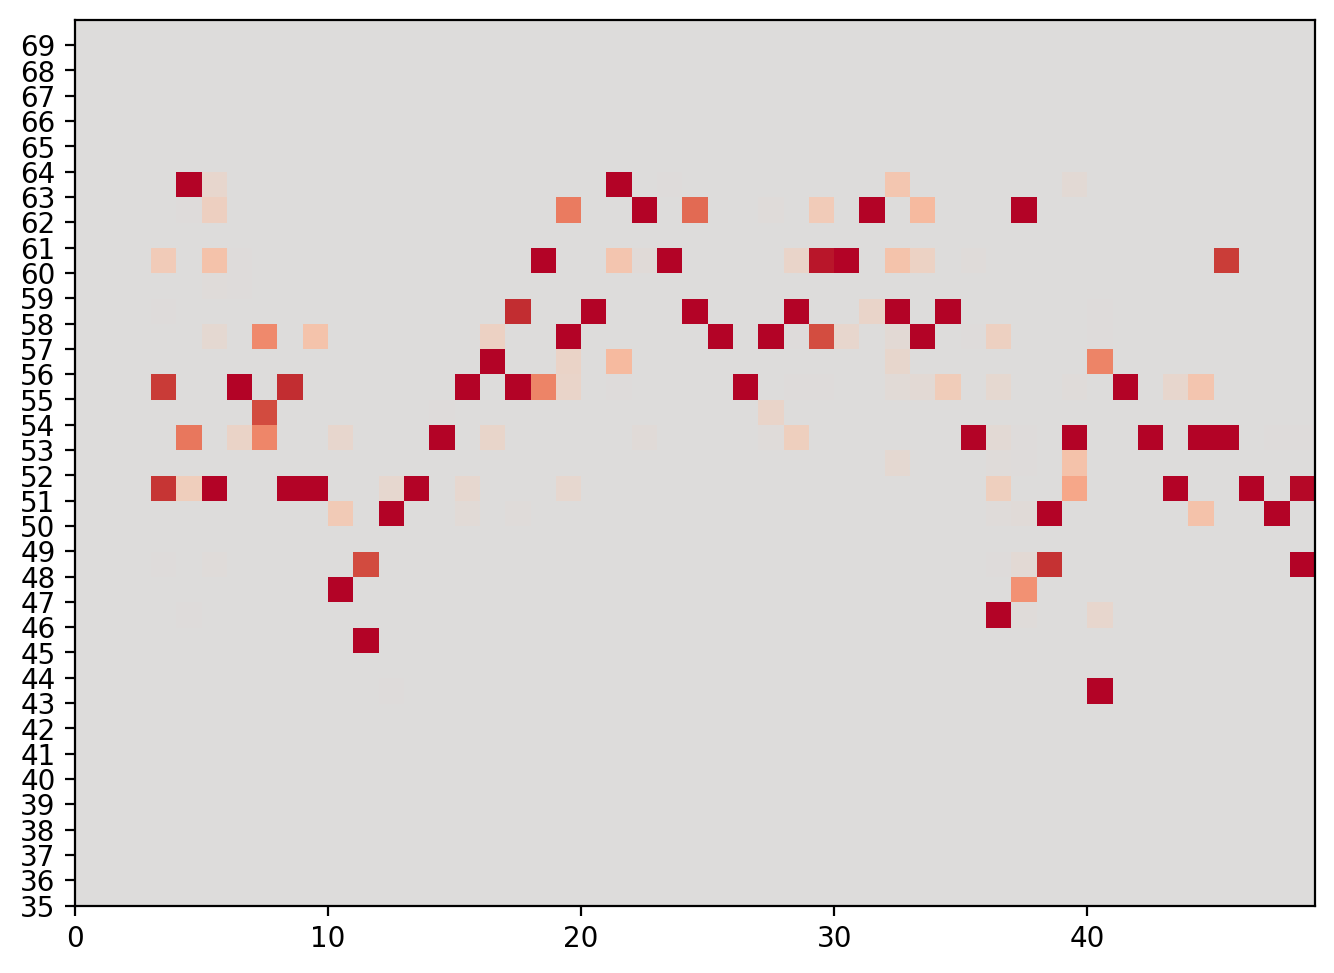

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()


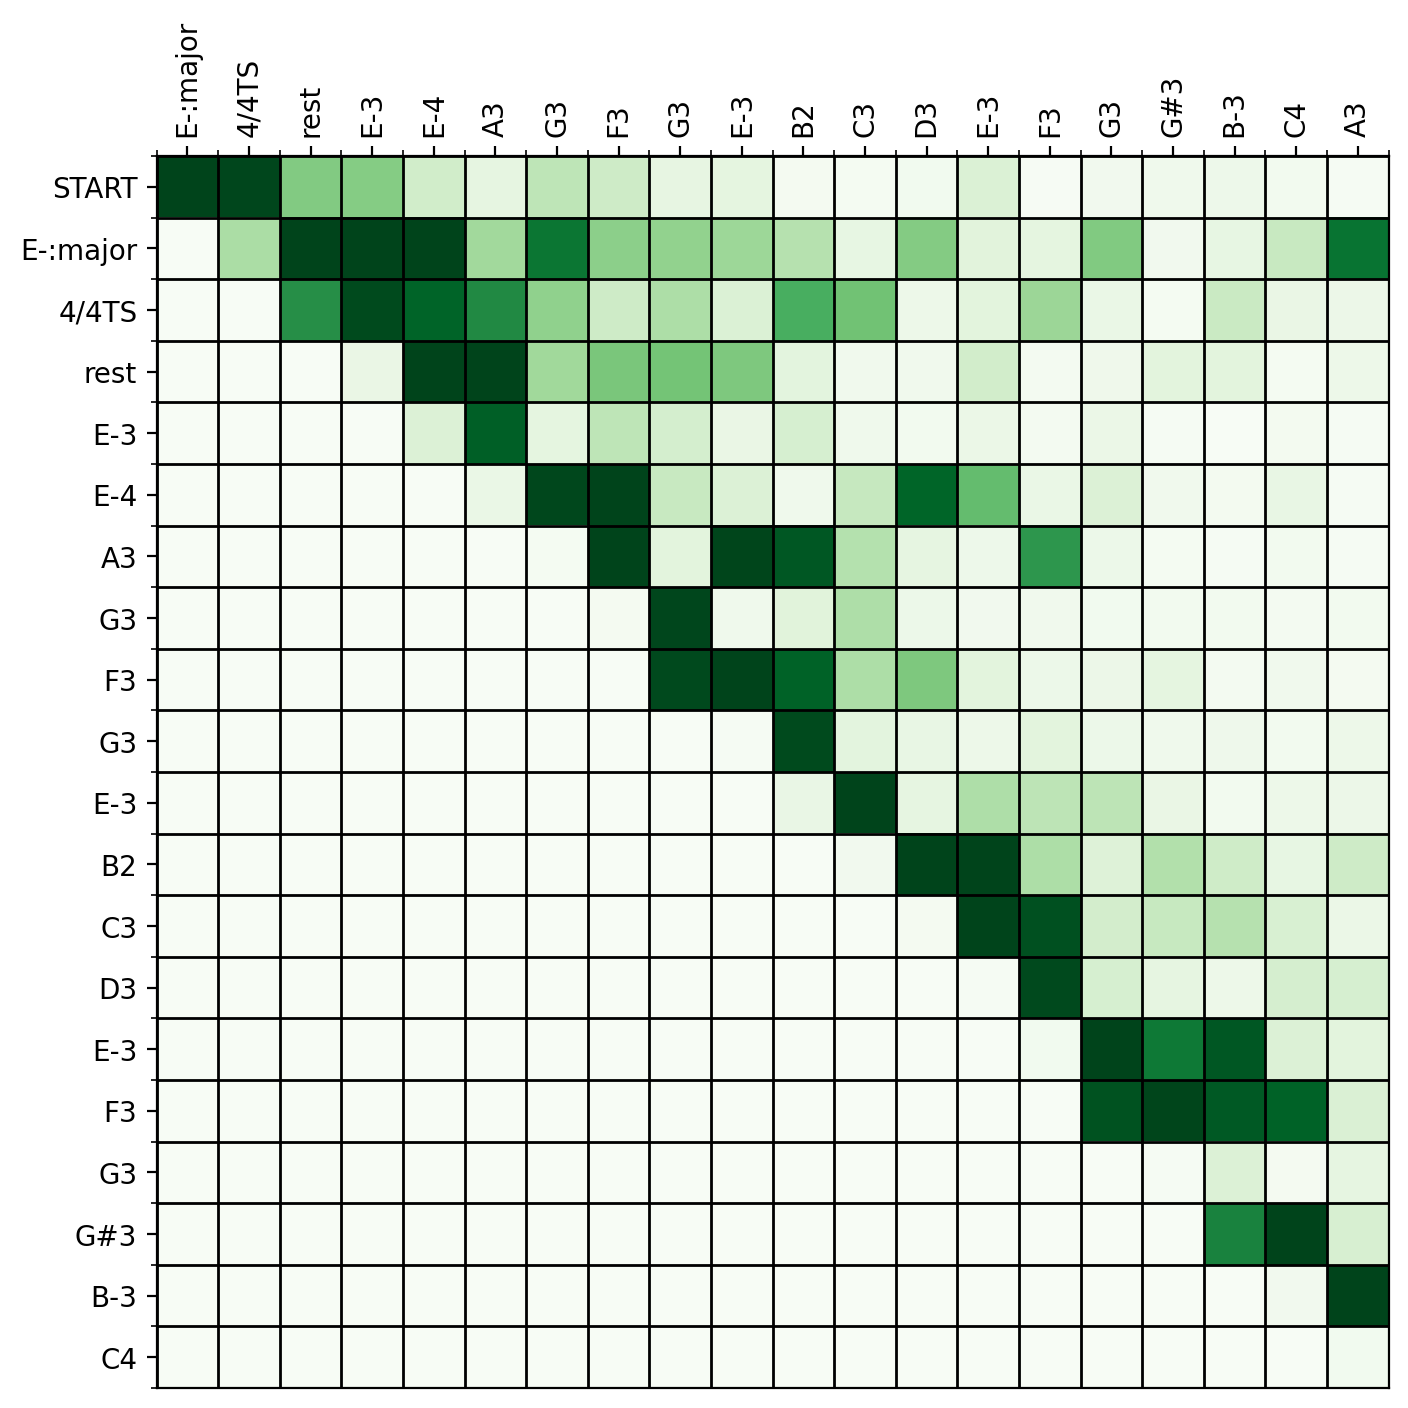

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()
